Steps for NLP Model Build:

A Capstone project applying NLP modeling to Amazon Question and Answer banks 

by Robert Spoonmore

# Data Source:
https://jmcauley.ucsd.edu/data/amazon/qa/qa_Grocery_and_Gourmet_Food.json.gz

***Citation:***

Modeling ambiguity, subjectivity, and diverging viewpoints in opinion question answering systems
Mengting Wan, Julian McAuley
International Conference on Data Mining (ICDM), 2016

Addressing complex and subjective product-related queries with customer reviews
Julian McAuley, Alex Yang
World Wide Web (WWW), 2016

# Data Import Instructions:

***Reading the data***
Data can be treated as python dictionary objects. A simple script to read any of the above the data is as follows:

def parse(path): g = gzip.open(path, 'r') for l in g: yield eval(l)


***Convert to 'strict' json***
The above data can be read with python 'eval', but is not strict json. If you'd like to use some language other than python, you can convert the data to strict json as follows:

import json import gzip def parse(path): g = gzip.open(path, 'r') for l in g: yield json.dumps(eval(l)) f = open("output.strict", 'w') for l in parse("qa_Video_Games.json.gz"): f.write(l + '\n')


***Pandas data frame***
This code reads the data into a pandas data frame:

import pandas as pd import gzip def parse(path): g = gzip.open(path, 'rb') for l in g: yield eval(l) def getDF(path): i = 0 df = {} for d in parse(path): df[i] = d i += 1 return pd.DataFrame.from_dict(df, orient='index') df = getDF('qa_Video_Games.json.gz')

In [1]:
# NOTE: RUN THIS IN ANACONDA ENVIROMENT WINDOW BEFORE RUNNING NOTEBOOK
# This prevents the 'IOPub data rate exceeded' error

# jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

In [110]:
# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

import json
import numpy as np
import pandas as pd
import gzip
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from gensim.models import doc2vec, Word2Vec, KeyedVectors
from gensim.models import TfidfModel
from gensim.models.doc2vec import TaggedDocument
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from scipy.spatial import distance
from gensim.models.phrases import Phrases, Phraser  # for bigram creation
from gensim import corpora
from gensim.corpora.dictionary import Dictionary    # for dictionary of corpus creation
from pprint import pprint
import transformers as ppb        # BERT model

In [3]:
# Define path for Amazon data
path = r'/Users/robertspoonmore/Desktop/Capstone datasets/qa_Grocery_and_Gourmet_Food.json.gz'

***Data Structure***

asin - ID of the product

questionType - type of question. Could be 'yes/no' or 'open-ended'

answerType - type of answer. Could be 'Y', 'N', or '?' (if the polarity of the answer could not be predicted). 

Only present for yes/no questions.

answerTime - raw answer timestamp

unixTime - answer timestamp converted to unix time

question - question text

answer - answer text

In [4]:
def parse(path): 
    g = gzip.open(path, 'rb') 
    for l in g: 
        yield eval(l) 
        
def getDF(path): 
    i = 0 
    df = {} 
    for d in parse(path): 
        df[i] = d 
        i += 1 
    return pd.DataFrame.from_dict(df, orient='index') 

food_df = getDF(path)

In [5]:
print("shape: ",food_df.shape,"\n")
print("columns: ",food_df.columns,"\n")
print("DF info: ",food_df.info(),"\n")
food_df.head()

shape:  (19538, 7) 

columns:  Index(['questionType', 'asin', 'answerTime', 'unixTime', 'question', 'answer',
       'answerType'],
      dtype='object') 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19538 entries, 0 to 19537
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   questionType  19538 non-null  object 
 1   asin          19538 non-null  object 
 2   answerTime    19538 non-null  object 
 3   unixTime      18930 non-null  float64
 4   question      19538 non-null  object 
 5   answer        19538 non-null  object 
 6   answerType    7294 non-null   object 
dtypes: float64(1), object(6)
memory usage: 1.2+ MB
DF info:  None 



,questionType,asin,answerTime,unixTime,question,answer,answerType
0,open-ended,9742356831,"Mar 26, 2014",1.395817e+09,What is the heat of this compared to the yello...,I think that the yellow is the most mild. The ...,NaN
1,yes/no,9742356831,"Apr 2, 2014",1.396422e+09,Is there MSG in it?,No MSG in Mae Ploy curry pastes.,N
2,open-ended,9742356831,"Apr 5, 2015",1.428217e+09,what are the ingredients exactly in this produ...,The ingredients are listed in the description!,NaN
3,open-ended,9742356831,"Aug 19, 2014",1.408432e+09,How important is the expiraci&oacute;n date on...,I never pay attention to it myself. The ingred...,NaN
4,open-ended,9742356831,"Aug 2, 2014",1.406963e+09,"The product description says 14 oz., but the p...",We bought the 14oz for just under $5.,NaN


In [6]:
# Create food dataframe holding the product id, question, and associated answer
food = food_df[['asin', 'question', 'answer']]
food.head()

,asin,question,answer
0,9742356831,What is the heat of this compared to the yello...,I think that the yellow is the most mild. The ...
1,9742356831,Is there MSG in it?,No MSG in Mae Ploy curry pastes.
2,9742356831,what are the ingredients exactly in this produ...,The ingredients are listed in the description!
3,9742356831,How important is the expiraci&oacute;n date on...,I never pay attention to it myself. The ingred...
4,9742356831,"The product description says 14 oz., but the p...",We bought the 14oz for just under $5.


In [7]:
# in viewing the df, look for missing values
print('shape: ',food.shape)
food.isna().sum()

shape:  (19538, 3)


asin        0
question    0
answer      0
dtype: int64

In [8]:
food.dtypes

asin        object
question    object
answer      object
dtype: object

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


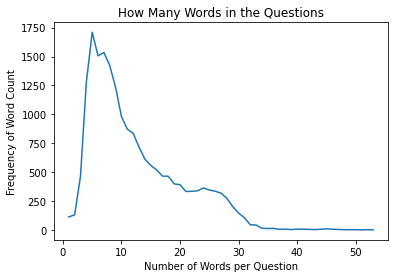

In [9]:
# Look at the word count of all the questions
food['words in question'] = food['question'].str.split().str.len()
word_count = food['words in question'].value_counts().sort_index(ascending=True)
labels = np.arange(1,len(word_count)+1,1)
plt.plot(labels,word_count)
plt.xlabel('Number of Words per Question')
plt.ylabel('Frequency of Word Count')
plt.title('How Many Words in the Questions')
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


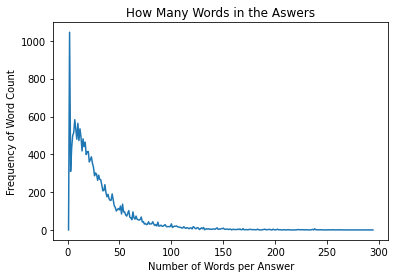

In [10]:
# Look at the word count of all the anwers
food['words in answer'] = food['answer'].str.split().str.len()
word_count = food['words in answer'].value_counts().sort_index(ascending=True)
labels = np.arange(1,len(word_count)+1,1)
plt.plot(labels,word_count)
plt.xlabel('Number of Words per Answer')
plt.ylabel('Frequency of Word Count')
plt.title('How Many Words in the Aswers')
plt.show()

In [11]:
# We must consider all answers regardless of size
# Look at the type of answers we see in the category
food['words in answer'].value_counts()

1      1045
6       583
9       564
11      535
7       529
       ... 
248       1
232       1
200       1
615       1
527       1
Name: words in answer, Length: 294, dtype: int64

In [12]:
# From first run, looking at bigrams, the phrase 'messin_sasquach' refers to a repeated question
# That question is "What's your favorite way of messin' with Sasquach?"
# This is determined to be an outlier and to be removed from the data
print("Count of questions before deltion: ",len(food))
food = food.loc[food["question"]!= "What's your favorite way of messin' with Sasquach?"]
print("Count of questions after deltion: ",len(food),"\n")

Count of questions before deltion:  19538
Count of questions after deltion:  19527 



In [13]:
# We can see that there are 1045 answers that are only one word
one_word_answers = food[food['words in answer']==1]

# Create a series of data from the answer column
one_word_answers = one_word_answers['answer'].squeeze()
# lower case all letters
one_word_answers = one_word_answers.str.lower()
# remove periods at end of the answers - some yes show up as yes.
one_word_answers = one_word_answers.str.rstrip('.!? \n\t')
print('Count of all one word answers: ',len(one_word_answers))
print('\nTop frequency one word answers: \n'
      ,one_word_answers.value_counts().head(10))
# we can see a large volumne of yes,no answers and simple responses
# Look at unique responses that are website addresses
#web_links = one_word_answers[one_word_answers.str.contains('www')]
print('\nAnswers that are links ("www"): ',len(one_word_answers[one_word_answers.str.contains('www')]))

Count of all one word answers:  1045

Top frequency one word answers: 
 yes           422
no            217
plastic        22
glass          11
                9
one             9
nope            7
absolutely      7
yep             6
powder          6
Name: answer, dtype: int64

Answers that are links ("www"):  15


In [14]:
# remove rows for questions that have only 1 or 2 words
food = food[food['words in question']>2]
print("shape :",food.shape)
print("min words per question: ",food['words in question'].min())
food.head()

shape : (19282, 5)
min words per question:  3


,asin,question,answer,words in question,words in answer
0,9742356831,What is the heat of this compared to the yello...,I think that the yellow is the most mild. The ...,13,23
1,9742356831,Is there MSG in it?,No MSG in Mae Ploy curry pastes.,5,7
2,9742356831,what are the ingredients exactly in this produ...,The ingredients are listed in the description!,9,7
3,9742356831,How important is the expiraci&oacute;n date on...,I never pay attention to it myself. The ingred...,10,22
4,9742356831,"The product description says 14 oz., but the p...",We bought the 14oz for just under $5.,20,8


In [15]:
#df[df['column name'].isna()]
na = food_df[food_df['answerTime']=='NaT']
print(na.count())
# verify no blanks in data

questionType    0
asin            0
answerTime      0
unixTime        0
question        0
answer          0
answerType      0
dtype: int64


# Preparing the question text data

In [16]:
# Import necessary modules
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
# Only need to run the first time
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/robertspoonmore/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/robertspoonmore/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/robertspoonmore/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Build a Dictionary of words for Questions and Answers 

A dictionary is a vectorized mapping of each word to a unique id location in the vector.  By creating a dictionary of all words in a document, a vector representing a location for each word is created.  The dictionary is then a map of the word locations

In [18]:
# Tokenize words within the phrase, not just a total bag of words
# method to tokenize anything sent to give back a list of list of words as they appeared
# strip out non-alphanumeric words (remove punctuation), remove stop words if requested
# return an overall list with phrase as separate list

def find_phrases(source, remove_stopwords=False):
    list_of_list_of_words = []
    for row in source:
        list_of_words = []
        tokens = word_tokenize(row)
        # Retain alphabetic words: alpha_only
        alpha_only = [t for t in tokens if t.isalpha()]
        # Lowercase
        lower_tokens = [t.lower() for t in alpha_only]
        # save resultant words
        if remove_stopwords:
            no_stops = [w for w in lower_tokens if w not in stopwords.words('english')]
            # save resultant words
            for word in no_stops:
                list_of_words.append(word)
        else:
            for word in lower_tokens:
                list_of_words.append(word)
        list_of_list_of_words.append(list_of_words)
        
    return list_of_list_of_words

In [19]:
# Find the most common words in the questions removing the stopwords 
question_words_all = find_phrases(food['question'], True)
q_dictionary = Dictionary(question_words_all)
print("Question Dictionary:\n",q_dictionary)

# Find the most common words in the answers removing the stopwords
answer_words_all = find_phrases(food['answer'], True)
a_dictionary = Dictionary(answer_words_all)
print("Answer Dictionary:\n",a_dictionary)

# Combine for total dictionary
all_words = question_words_all + answer_words_all
all_dictionary = Dictionary(all_words)
print("Combined Dictionaries:\n",all_dictionary)

Question Dictionary:
 Dictionary(9227 unique tokens: ['compared', 'curry', 'heat', 'red', 'yellow']...)
Answer Dictionary:
 Dictionary(16368 unique tokens: ['deeper', 'flavor', 'green', 'mild', 'much']...)
Combined Dictionaries:
 Dictionary(18630 unique tokens: ['compared', 'curry', 'heat', 'red', 'yellow']...)


# Create Bag of Words Corpus for Questions and Answers

A Bag Of Words Corpus is a vector with the word id's and the count frequency of each word found in the document.

In [20]:
# Create corpus for questions
q_dict = Dictionary()
q_corpus = [q_dict.doc2bow(word, allow_update=True) for word in question_words_all]
print("question Corpus word count: ",len(q_corpus))

q_word_counts = [[(q_dict[id],count) for id, count in line] for line in q_corpus]

question Corpus word count:  19282


In [21]:
# Create corpus for answers
a_dict = Dictionary()
a_corpus = [a_dict.doc2bow(word, allow_update=True) for word in answer_words_all]
print("answer Corpus word count: ",len(a_corpus))

answer Corpus word count:  19282


In [22]:
# Create corpus for all words, combined questions and answers
all_dict = Dictionary()
all_corpus = [all_dict.doc2bow(word, allow_update=True) for word in all_words]
print("All words Corpus count: ",len(all_corpus))

All words Corpus count:  38564


# Create TF-IDF matrix

The TF-IDF (Term Frequency - Inverse Document Frequency) takes the bag of words corpus and down weight the words that appear most frequently.  This normalizes the results to keep the high use words from dominating

In [23]:
# Create TF-IDF model for questions
q_tfidf = TfidfModel(q_corpus, smartirs='ntc')

for doc in q_tfidf[q_corpus]:
    [[q_dict[id],np.around(freq,decimals=2)] for id, freq in doc]
q_tfidf_words = []
for score, phrase in q_dict.items():
    q_tfidf_words.append([score,phrase])
q_tfidf_words.sort(reverse=True)
print("Top Question Words: ")
pprint(q_tfidf_words[0:25])

Top Question Words: 
[[9226, 'briefly'],
 [9225, 'adore'],
 [9224, 'dips'],
 [9223, 'refect'],
 [9222, 'gather'],
 [9221, 'satisfactory'],
 [9220, 'resembling'],
 [9219, 'dientions'],
 [9218, 'packageing'],
 [9217, 'overflows'],
 [9216, 'overflowing'],
 [9215, 'fault'],
 [9214, 'disabling'],
 [9213, 'adapter'],
 [9212, 'keuring'],
 [9211, 'nishio'],
 [9210, 'straining'],
 [9209, 'radiated'],
 [9208, 'fucoshima'],
 [9207, 'gym'],
 [9206, 'numbered'],
 [9205, 'cleanses'],
 [9204, 'weekend'],
 [9203, 'literature'],
 [9202, 'knew']]


In [24]:
# Create TF-IDF model for answers
a_tfidf = TfidfModel(a_corpus, smartirs='ntc')
for doc in a_tfidf[a_corpus]:
    [[a_dict[id],np.around(freq,decimals=2)] for id, freq in doc]
a_tfidf_words = []
for score, phrase in a_dict.items():
    a_tfidf_words.append([score,phrase])
a_tfidf_words.sort(reverse=True)
print("Top Answer Words: ")
pprint(a_tfidf_words[0:25])

Top Answer Words: 
[[16367, 'cherios'],
 [16366, 'reminding'],
 [16365, 'zing'],
 [16364, 'oligosaccharide'],
 [16363, 'oliver'],
 [16362, 'poop'],
 [16361, 'carriers'],
 [16360, 'deordorized'],
 [16359, 'discipline'],
 [16358, 'delldirect'],
 [16357, 'owed'],
 [16356, 'pointy'],
 [16355, 'forewarned'],
 [16354, 'ceomom'],
 [16353, 'warranty'],
 [16352, 'messing'],
 [16351, 'triclycerides'],
 [16350, 'brakes'],
 [16349, 'buylipix'],
 [16348, 'spenda'],
 [16347, 'cardio'],
 [16346, 'tps'],
 [16345, 'lipix'],
 [16344, 'tbeir'],
 [16343, 'insides']]


In [25]:
# Create TF-IDF model for all words
all_tfidf = TfidfModel(all_corpus, smartirs='ntc')
for doc in all_tfidf[all_corpus]:
    [[all_dict[id],np.around(freq,decimals=2)] for id, freq in doc]
all_tfidf_words = []
for score, phrase in all_dict.items():
    all_tfidf_words.append([score,phrase])
all_tfidf_words.sort(reverse=True)
print("Top Answer Words: ")
pprint(all_tfidf_words[0:25])

Top Answer Words: 
[[18629, 'cherios'],
 [18628, 'reminding'],
 [18627, 'oligosaccharide'],
 [18626, 'carriers'],
 [18625, 'deordorized'],
 [18624, 'discipline'],
 [18623, 'delldirect'],
 [18622, 'owed'],
 [18621, 'pointy'],
 [18620, 'forewarned'],
 [18619, 'ceomom'],
 [18618, 'messing'],
 [18617, 'triclycerides'],
 [18616, 'brakes'],
 [18615, 'buylipix'],
 [18614, 'spenda'],
 [18613, 'cardio'],
 [18612, 'tps'],
 [18611, 'lipix'],
 [18610, 'tbeir'],
 [18609, 'dictate'],
 [18608, 'vommon'],
 [18607, 'tempetures'],
 [18606, 'perspective'],
 [18605, 'kagoushima']]


# Create Bigrams finding combined terms

A bigram is a two word phrase that typically appears together to identify something unique.  
A trigram is a three word phrase.
Identifying the bigrams and trigrams makes the phrases appear as two_word and three_word_phrases 
in the corpus, thus combining the terms hand improving context identification

The questions and answers were sampled for trigrams, but not found to be significant
Only Bigrams will be applied

In [71]:
# Find the Bigrams in the questions
q_bigram = Phrases(answer_words_all, min_count=5, threshold=10)
print("Top answer bigrams found:")
q_bigram_list = []
for phrase, score in q_bigram.find_phrases(answer_words_all).items():
    q_bigram_list.append([score,phrase])
q_bigram_list.sort(reverse=True)
pprint(q_bigram_list[0:20])

Top answer bigrams found:
[[9026.203125, 'chocolaty_rerfer'],
 [8752.681818181818, 'possibilities_jimmies'],
 [8558.177777777779, 'aspergillus_oryzae'],
 [8079.398601398601, 'drift_pollinators'],
 [7220.9625, 'sri_lanka'],
 [6912.374358974358, 'dolce_gusto'],
 [6877.107142857142, 'trading_gbi'],
 [6877.107142857142, 'puerto_rico'],
 [6877.107142857142, 'muir_glen'],
 [6583.213675213676, 'margaret_igourmet'],
 [6564.511363636363, 'beta_carotene'],
 [6178.363636363637, 'happed_transit'],
 [5675.4231578947365, 'flores_employee'],
 [5528.00956937799, 'tim_hortons'],
 [5501.685714285714, 'kicking_horse'],
 [5348.86111111111, 'noe_rincon'],
 [5290.082417582417, 'santa_trading'],
 [5094.153439153439, 'dot_com'],
 [4813.975, 'monosodium_glutamate'],
 [4584.738095238095, 'sorbitan_monostearate']]


In [72]:
# Find the Bigrams in the answers
a_bigram = Phrases(answer_words_all, min_count=5, threshold=10)
print("Top answer bigrams found:")
a_bigram_list = []
for phrase, score in a_bigram.find_phrases(answer_words_all).items():
    a_bigram_list.append([score,phrase])
a_bigram_list.sort(reverse=True)
pprint(a_bigram_list[0:20])

Top answer bigrams found:
[[9026.203125, 'chocolaty_rerfer'],
 [8752.681818181818, 'possibilities_jimmies'],
 [8558.177777777779, 'aspergillus_oryzae'],
 [8079.398601398601, 'drift_pollinators'],
 [7220.9625, 'sri_lanka'],
 [6912.374358974358, 'dolce_gusto'],
 [6877.107142857142, 'trading_gbi'],
 [6877.107142857142, 'puerto_rico'],
 [6877.107142857142, 'muir_glen'],
 [6583.213675213676, 'margaret_igourmet'],
 [6564.511363636363, 'beta_carotene'],
 [6178.363636363637, 'happed_transit'],
 [5675.4231578947365, 'flores_employee'],
 [5528.00956937799, 'tim_hortons'],
 [5501.685714285714, 'kicking_horse'],
 [5348.86111111111, 'noe_rincon'],
 [5290.082417582417, 'santa_trading'],
 [5094.153439153439, 'dot_com'],
 [4813.975, 'monosodium_glutamate'],
 [4584.738095238095, 'sorbitan_monostearate']]


In [73]:
# Find the Bigrams in all phrases
all_bigram = Phrases(all_words, min_count=5, threshold=10)
print("Top bigrams found in all phrases:")
all_bigram_list = []
for phrase, score in all_bigram.find_phrases(all_words).items():
    all_bigram_list.append([score,phrase])
all_bigram_list.sort(reverse=True)
pprint(all_bigram_list[0:20])

Top bigrams found in all phrases:
[[11782.024691358025, 'hong_kong'],
 [10603.822222222223, 'aspergillus_oryzae'],
 [10010.601398601399, 'drift_pollinators'],
 [9941.083333333332, 'puerto_rico'],
 [9543.44, 'muir_glen'],
 [8836.518518518518, 'sorbitan_monostearate'],
 [8520.92857142857, 'trading_gbi'],
 [8520.92857142857, 'luo_han'],
 [7779.978260869565, 'beta_carotene'],
 [7069.214814814815, 'margaret_igourmet'],
 [7032.008421052631, 'flores_employee'],
 [6627.388888888889, 'noe_rincon'],
 [6627.388888888889, 'fog_chaser'],
 [6390.696428571428, 'dolce_gusto'],
 [6296.019444444444, 'sri_lanka'],
 [6278.578947368421, 'kicking_horse'],
 [6117.589743589743, 'bug_infested'],
 [6024.898989898989, 'dot_com'],
 [5858.138392857143, 'monosodium_glutamate'],
 [5680.619047619048, 'santa_trading']]


# Create Topic Models with Hdp

Topic Modeling extracts the underlying topics giving the terms that have a relative combination of terms.  
The Hdp model is used when we have an unsupervised model - outputs not labeled
We must provide a best guess for the top number of topics, and the model shows the topic keywords found most

In [38]:
# Apply models from gensim for topic modeling applied only to the questions
# Use Hdp Model for unsupervised model - since we have no absolute confirmation on questions being answered
from gensim.models import HdpModel

q_hdpmodel = HdpModel(corpus=q_corpus,id2word=q_dictionary,random_state=23)
# Visualize top Hdp Predictions
n_topics = 6
q_topic_words = pd.DataFrame({})
    
for i, topic in enumerate(q_hdpmodel.get_topics()[:n_topics]):
    top_feature_ids = topic.argsort()[-10:][::-1]
    feature_values = topic[top_feature_ids]
    words = [q_dictionary[id] for id in top_feature_ids]
    topic_df = pd.DataFrame({'value': feature_values, 'word': words, 'topic': i})
    q_topic_words = pd.concat([q_topic_words, topic_df], ignore_index=True)
q_topic_words.head(n_topics)

,value,word,topic
0,0.001441,product,0
1,0.001239,use,0
2,0.001186,many,0
3,0.001135,thanks,0
4,0.001063,date,0
5,0.001022,ingredients,0


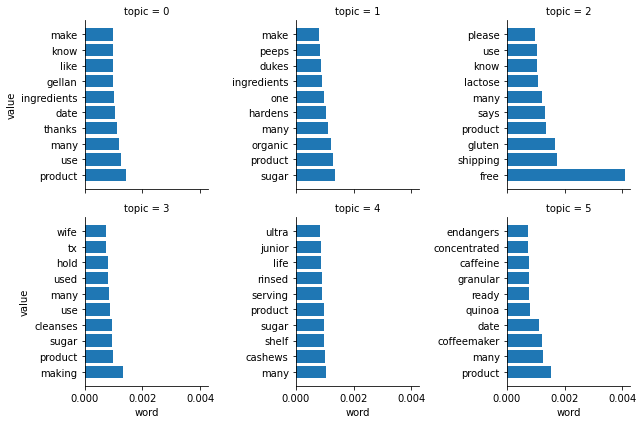

In [39]:
# Graph the magnatude of the relative terms for each topic
g = sns.FacetGrid(q_topic_words, col="topic", col_wrap=3, sharey=False)
g.map(plt.barh, "word", "value")

# Topics identified through looking up the top words in the questions

1) **Product understanding:** Questions about contents, use, quantities, shelf life, expiration date

2) **Is product organic?:** Questions about organic nature and ingredients tied to organic nature

3) **Product shipment and conditions:** Questions about cost and type of shipping

4) **Product application and what can be made from it:** Questions about what it will make, ingredients, and application

5) **Product sourcing conditions:** How many of types of ingredients, contents, how prepared for shipment

6) **Product match to equipment:** Concerns on applicability to coffee maker types, concentrations, expiration date

In [40]:
# Apply models from gensim for topic modeling applied only to the answers
# Use Hdp Model for unsupervised model - since we have no absolute confirmation on questions being answered
from gensim.models import HdpModel

a_hdpmodel = HdpModel(corpus=a_corpus,id2word=a_dictionary,random_state=23)
# Visualize top Hdp Predictions
n_words = 9
a_topic_words = pd.DataFrame({})
    
for i, topic in enumerate(a_hdpmodel.get_topics()[:n_words]):
    top_feature_ids = topic.argsort()[-10:][::-1]
    feature_values = topic[top_feature_ids]
    words = [a_dictionary[id] for id in top_feature_ids]
    topic_df = pd.DataFrame({'value': feature_values, 'word': words, 'topic': i})
    a_topic_words = pd.concat([a_topic_words, topic_df], ignore_index=True)
a_topic_words.head()

,value,word,topic
0,0.007756,use,0
1,0.006674,would,0
2,0.006036,product,0
3,0.005568,like,0
4,0.005494,organic,0


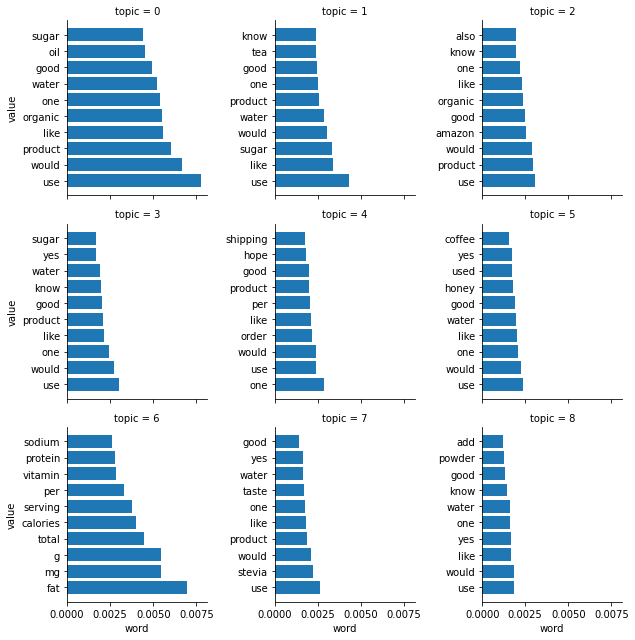

In [41]:
# Graph the magnatude of the relative terms for each topic
g2 = sns.FacetGrid(a_topic_words, col="topic", col_wrap=3, sharey=False)
g2.map(plt.barh, "word", "value")

# Topics identified through looking up the top words in the answers

1) **Product use instructions:** Long worded explainations about how to use, many starting with "I have not..."

2) **Application similies:** This is like..., use this product like..., OR if you like ... then this product is for you

3) **Answer deflections:** User referencing what Amazon says about product directly

4) **Product Ingredients Detailed listing:** A restatement of contents in more detail

5) **Product substitutions:** Can product be used as a substitute, or can something be substituted for it

6) inconclusive, appears similar to above categories



# Train Word2Vec model with Gensim

The Word2Vec model looks at all phrases and creates a vector based upon the frequency of words found 
based upon the bigram loaded corpus

In [74]:
# Train the Word2Vec model
def train_model(word_list):
   for i, list_of_words in enumerate(word_list):
      yield TaggedDocument(list_of_words, [i])
train_data = list(train_model(all_words))

In [75]:
# Initialize the Model
d2v_model = doc2vec.Doc2Vec(vector_size=1000, min_count=2, workers=3, seed=86, epochs=30)

# Build Vocabulary
d2v_model.build_vocab(train_data)

In [76]:
################# This step takes some time - reload model if needed #################
import time
start_time = time.time()
d2v_model.train(train_data, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)
print("Time to train the model: ",round(time.time()-start_time),"seconds")
# Save model
d2v_model.save('d2v_food.model')

Time to train the model:  46 seconds


# Plot the words found using PCA to reduce dimensions

In [77]:
# more to come on this

# Create Document Vectors

In [78]:
# Load model created in prior notebook based on the food data
d2v_model= doc2vec.Doc2Vec.load("d2v_food.model")

In [79]:
# Infer vectors for all questions into new list to keep order
question_vectors = []
for q in question_words_all:
    question_vectors.append(d2v_model.infer_vector(q))
print("Question Vectors count: \n",len(question_vectors))

Question Vectors count: 
 19282


In [80]:
# Infer vectors for all answers into new list to keep order
answer_vectors = []
for a in answer_words_all:
    answer_vectors.append(d2v_model.infer_vector(a))
print("Answer Vectors count: \n",len(answer_vectors))

Answer Vectors count: 
 19282


# Determine Cosine angle between questions and answers

In [81]:
# Determine Cosine between vectors
# Add feature to food dataframe to hold the cosine distance vector between question and answer
from scipy import spatial

food['cosine_dist'] = [spatial.distance.cosine(question_vectors[row], answer_vectors[row]) 
                       for row,element in enumerate(question_vectors)]
cosine_values = food['cosine_dist']
print("Number of values: ",len(cosine_values))
print(cosine_values.value_counts())

Number of values:  19282
0.478916    2
0.374313    2
0.640409    2
0.521760    2
0.653968    2
           ..
0.590667    1
0.667585    1
0.061314    1
0.929244    1
0.892450    1
Name: cosine_dist, Length: 19275, dtype: int64


count    19282.000000
mean         0.627037
std          0.238681
min          0.020548
25%          0.468698
50%          0.652686
75%          0.801561
max          1.454319
Name: cosine_dist, dtype: float64



(array([3.070e+02, 5.120e+02, 5.790e+02, 8.310e+02, 1.006e+03, 1.237e+03,
        1.560e+03, 1.874e+03, 2.147e+03, 2.359e+03, 2.285e+03, 1.837e+03,
        1.259e+03, 9.870e+02, 3.810e+02, 7.600e+01, 3.000e+01, 1.200e+01,
        2.000e+00, 1.000e+00]),
 array([0.02054751, 0.0922361 , 0.1639247 , 0.2356133 , 0.30730189,
        0.37899049, 0.45067908, 0.52236768, 0.59405627, 0.66574487,
        0.73743346, 0.80912206, 0.88081065, 0.95249925, 1.02418784,
        1.09587644, 1.16756504, 1.23925363, 1.31094223, 1.38263082,
        1.45431942]),
 <BarContainer object of 20 artists>)

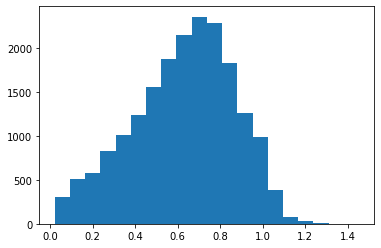

In [82]:
# Look at the distribution of the differences
# Making a histogram of the cosine variable values
print(cosine_values.describe())
print()
plt.hist(cosine_values,bins=20)

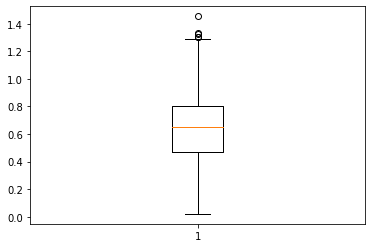

In [83]:
# As shown in the statistics for the cosine values
# The average difference between the Q and A vectors is 0.63 with std of 0.24
plt.boxplot(cosine_values)
plt.show()

In [84]:
# How many questions receive answers below limit?
limit = 0.75
# Limit determined from best practice of other comparisons

wrong_answer_count = food['cosine_dist'][abs(food['cosine_dist'])<limit].count()
right_answer_count = food['cosine_dist'][abs(food['cosine_dist'])>=limit].count()
# Print percentage of potential wrong answers
print("If correctness of answer is based on cosine distance less than: ", limit)
print("Potential wrong answer count: ",wrong_answer_count)
print("Potential right answer count: ",right_answer_count)
print("Potential wrong answer percentage: ",100*wrong_answer_count/(wrong_answer_count+right_answer_count))

If correctness of answer is based on cosine distance less than:  0.75
Potential wrong answer count:  12840
Potential right answer count:  6442
Potential wrong answer percentage:  66.59060263458147


In [85]:
# Does this account for Yes answers?
yes_answers = food[(food['answer'].str.lower()=='yes') | (food['answer'].str.lower()=='yes.')]
yes_count_right = yes_answers['cosine_dist'][abs(yes_answers['cosine_dist'])>=limit].count()
yes_count_wrong = yes_answers['cosine_dist'][abs(yes_answers['cosine_dist'])<limit].count()
print("Yes answers with measure above limit: ",yes_count_right)
print("Yes answers with measure below limit: ",yes_count_wrong)
print('\nDistribution of coine_dist for YES answers',yes_answers['cosine_dist'].describe())

Yes answers with measure above limit:  45
Yes answers with measure below limit:  353

Distribution of coine_dist for YES answers count    398.000000
mean       0.449501
std        0.220745
min        0.180366
25%        0.272897
50%        0.386886
75%        0.578526
max        1.102080
Name: cosine_dist, dtype: float64


In [102]:
# Look at negative YES answers
negative_yes_answers = yes_answers[['question','answer','cosine_dist']][abs(yes_answers['cosine_dist'])<limit]
print("count: ",negative_yes_answers.size)
negative_yes_answers.head(25)
                       

count:  1059


,question,answer,cosine_dist
8,Can you dye eggs?,Yes,0.421194
109,are these almonds nonpareils?,yes,0.628836
140,Comes with the connecter thing? I have gold me...,Yes,0.651795
194,is this edible,Yes,0.295259
280,Is papaya used in this bee pollen powder organic?,Yes,0.541885
360,is it gluten free,Yes,0.231620
375,Is this gluten free?,Yes,0.350125
383,Is this alcohol free?,Yes.,0.325157
417,can I make pesto with this?,Yes,0.336874
454,Is this a fine powder?,Yes,0.202552


In [103]:
# Does this account for No answers?
no_answers = food[(food['answer'].str.lower()=='no') | (food['answer'].str.lower()=='no.')]
no_count_right = no_answers['cosine_dist'][abs(no_answers['cosine_dist'])>=limit].count()
no_count_wrong = no_answers['cosine_dist'][abs(no_answers['cosine_dist'])<limit].count()
print("NO answers with measure above limit: ",no_count_right)
print("NO answers with measure below limit: ",no_count_wrong)
print('\nDistribution of coine_dist for YES answers',no_answers['cosine_dist'].describe())

NO answers with measure above limit:  211
NO answers with measure below limit:  0

Distribution of coine_dist for YES answers count    211.000000
mean       1.000501
std        0.028786
min        0.927798
25%        0.982711
50%        1.000144
75%        1.016841
max        1.089494
Name: cosine_dist, dtype: float64


The cosine differences appear to be distributed around a mean that is below the target limit for alignment

# Levenshtein Distance between quesions and answers

In [104]:
# Determine Levenshtein di)stance between vectors
# The Levenshtein distance is a number that tells you how different two strings are. 
# The higher the number, the more different the two strings are.

In [105]:
# Import pylev for levenshtein method to determine a value based on two string sequences
import pylev
food['levenshtein_dist'] = [pylev.levenshtein(question_words_all[row],answer_words_all[row]) 
                       for row,element in enumerate(question_words_all)]
levenshtein_values = food['levenshtein_dist']
print("Number of values: ",len(levenshtein_values))
print(levenshtein_values.describe())

Number of values:  19282
count    19282.000000
mean        15.174723
std         19.108870
min          0.000000
25%          6.000000
50%         10.000000
75%         18.000000
max        628.000000
Name: levenshtein_dist, dtype: float64


(array([1.740e+04, 1.433e+03, 2.850e+02, 8.600e+01, 3.800e+01, 1.500e+01,
        8.000e+00, 5.000e+00, 4.000e+00, 1.000e+00, 3.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  0. ,  31.4,  62.8,  94.2, 125.6, 157. , 188.4, 219.8, 251.2,
        282.6, 314. , 345.4, 376.8, 408.2, 439.6, 471. , 502.4, 533.8,
        565.2, 596.6, 628. ]),
 <BarContainer object of 20 artists>)

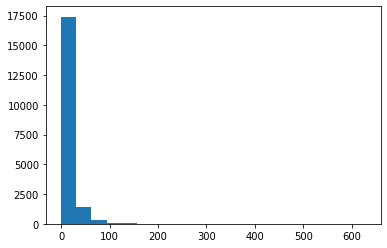

In [106]:
# Look at the distribution of the differences
# Making a histogram of the cosine variable values
plt.hist(levenshtein_values,bins=20)

In [108]:
# Save samples results to excel file
data_with_cosine_diff = r'Capstone_Dataset/Amazon_Food_Q_A_Cosines_Dist_Sample.xlsx'
food.to_excel(data_with_cosine_diff)

# Apply BERT method for answer prediction

BERT stands for Bidirectional Encoder Representations from Transformers. 
It is and NLP approach designed to pre-train from unlabeled text 
by jointly conditioning on both left and right context. 


In [118]:
# BERT requires all lists to be the same size for batch processing
# We will padd the question lists to be the same size
max_len = 0
for i in question_words_all:
    if len(i) > max_len:
        max_len = len(i)

q_padded = np.array([i + [0]*(max_len-len(i)) for i in question_words_all])
np.array(q_padded).shape

(19282, 29)

In [119]:
# We will padd the answer lists to be the same size
max_len = 0
for i in answer_words_all:
    if len(i) > max_len:
        max_len = len(i)

a_padded = np.array([i + [0]*(max_len-len(i)) for i in answer_words_all])
np.array(a_padded).shape

(19282, 634)

In [122]:
# Set up mask to avoid the padding for the process
a_attention_mask = np.where(a_padded != 0, 1, 0)
a_attention_mask.shape

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


ValueError: either both or neither of x and y should be given